In [1]:
import scipy as scp
import numpy as np
import itertools
import collections

In [2]:
def iterer(*args):
    return itertools.product(*[x_ if isinstance(x_,collections.Iterable) else range(x_) for x_ in args])

In [3]:
import sys

### All necessary functions for convertions

In [444]:
class HelioConverter():
    AU = 149597870.691
    def __init__(self, cenX, cenY, rad, R, ϕ, θ, dist):
        self.cut = None
        self.cenX = cenX
        self.cenY = cenY
        self.dist_top = cenY - rad
        self.rad = rad
        self.R = R
        self.ϕ = ϕ
        self.θ = θ
        self.set_rad_parallel_cut(self.rad)
        self.dist = dist
    
    def get_point(self):
        return np.array([[self.dist*self.AU], [0], [0]])
    
    def HEEQ_to_point_sat_matrix(self, ϕ, θ):
        return np.array([
            [np.cos(ϕ)*np.cos(θ), np.sin(ϕ)*np.cos(θ), np.sin(θ)],
            [-np.sin(ϕ), np.cos(ϕ), 0],
            [-np.cos(ϕ)*np.sin(θ), -np.sin(ϕ)*np.sin(θ), np.cos(θ)]
        ])
    
    def point_sat_to_HEEQ_matrix(self, ϕ, θ):
        return np.array([
            [np.cos(ϕ)*np.cos(θ), - np.sin(ϕ), - np.cos(ϕ)*np.sin(θ)],
            [np.sin(ϕ)*np.cos(θ), np.cos(ϕ), - np.sin(ϕ)*np.sin(θ)],
            [np.sin(θ), 0,  np.cos(θ)]
        ])
    
    def HEEQ_to_point_sat(self, p):
        return self.HEEQ_to_point_sat_matrix(self.ϕ, self.θ).dot(p)
    
    def point_sat_to_HEEQ(self, p):
        return self.point_sat_to_HEEQ_matrix(self.ϕ, self.θ).dot(p)
    
    def to_HEEQ(self, X1):
        return np.array([X1*np.cos(self.ϕ)*np.cos(self.Θ), X1*np.sin(self.ϕ)*np.cos(self.θ), X1*np.sin(self.θ)])
    
    def rad_circle(self, i):
        return self.cut[i]
    
    def nanleft(self, i):
        return self.cenX - self.cut[i]
    
    def set_rad_parallel_cut(self, rad):
        self.cut = np.zeros((2*rad+1,1))
        self.cut[:rad] = np.fix(np.sqrt(rad**2-(rad-np.array(list(range(rad))))**2))[:,np.newaxis]
        self.cut[rad] = self.cenX - (self.dist_top + 1)
        #print(self.cut[rad], rad)
        self.cut[rad+1:] = self.cut[:rad][::-1]
    
    def coord_real_to_pixel(self, Y,Z):
        i=int(self.rad + self.dist_top - np.fix(Z*self.rad/self.R))
        j=int(np.fix(self.nanleft(i-self.dist_top) + self.rad_circle(i-self.dist_top) + Y*self.rad/self.R))
        return i,j
    
    def pixel_to_real(self, i,j):
        Y=(j-self.nanleft(i-self.dist_top)-self.rad_circle(i-self.dist_top))*(self.R/self.rad);  
        Z=(-(i-self.rad-self.dist_top))*(self.R/self.rad);           
        X=np.sqrt(self.R**2-Y**2-Z**2);
        return np.array([[X[0]],[Y[0]],[Z]])
    

In [445]:
imA = np.loadtxt("20071207_A_Dif_0435_0415.txt")

In [446]:
imB = np.loadtxt("20071207_B_Dif_0435_0415.txt")

In [447]:
imA[imA==0]=np.nan

In [448]:
imB[imB==0]=np.nan

In [449]:
import matplotlib.pyplot as plt

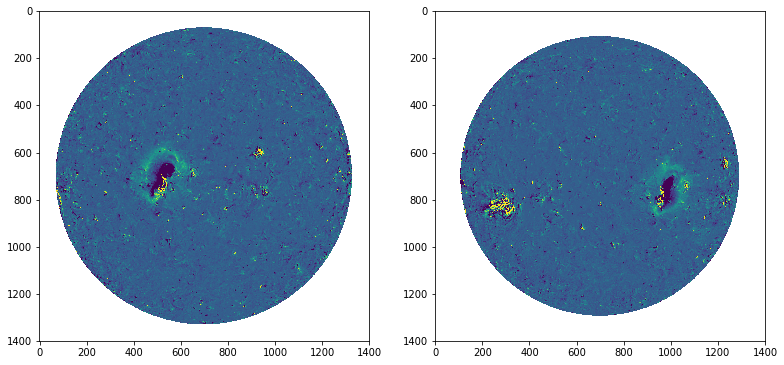

In [450]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,7))

ax1.imshow(imA,vmin=-30,vmax=70)
ax2.imshow(imB,vmin=-30,vmax=70)

In [541]:
n = np.array([673,991])

In [542]:
HCA = HelioConverter(700,700,630,701407,20.620/180*np.pi,-2.535/180*np.pi, 0.966587)
HCB = HelioConverter(700,700,593,701407,-21.424/180*np.pi,3.089/180*np.pi, 1.026675)

In [543]:
N = HCB.pixel_to_real(n[0],n[1])

In [544]:
N

array([[610311.0583988 ],
       [344198.03878583],
       [ 31935.9005059 ]])

In [545]:
B = HCB.get_point()
A = HCA.get_point()

In [546]:
from scipy.optimize import minimize_scalar

In [547]:
def F(C,A,R):
    def fun(dt):
        return np.abs( np.sum((C + (C-A)*dt)**2) - R**2)
    return fun

In [576]:
Ms = []
Cs = []
for dt in np.linspace(0,0.0008,1000):
    C = N + (B-N)*dt
    C_heeq = HCB.point_sat_to_HEEQ(C)
    C_a = HCA.HEEQ_to_point_sat(C_heeq)
    Cs.append(C_a)
    opt_result = minimize_scalar(F(C_a, A, HCA.R))
    M = C_a + (C_a-A)*opt_result.x
    #print(M, F(C_a, A, HCA.R)(opt_result.x))
    Ms.append(M)    

In [577]:
imA_with_line = imA.copy()
imB_with_line = imB.copy()

In [579]:
for ms in Ms:
    #print(ms.flatten())
    m = HCA.coord_real_to_pixel(*(ms.flatten()[1:].tolist()))
    #print(m)
    for dm0,dm1 in iterer(range(-1,2),range(-1,2)):
        #if m[0] + dm0 in range(0,1400) and m[1] + dm1 in range(0,1400):
        imA_with_line[m[0]+dm0][m[1]+dm1] = np.nan

#### Height of the point

In [589]:
np.sqrt(np.sum(HCA.point_sat_to_HEEQ(Cs[-1])**2))-HCA.R

108618.2352242819

In [584]:
for dn00 in range(-10, 10):
    for dn0,dn1 in iterer(range(0,2),range(0,2)):
            imB_with_line[n[0]+dn0 +dn00][n[1]+dn1] = np.nan
            imB_with_line[n[0]+dn0 ][n[1]+dn1+dn00] = np.nan

In [585]:
for dn00 in range(-10, 10):
    for dn0,dn1 in iterer(range(0,2),range(0,2)):
            imA_with_line[m[0]+dn0 +dn00][m[1]+dn1] = np.nan
            imA_with_line[m[0]+dn0 ][m[1]+dn1+dn00] = np.nan

### A with line 

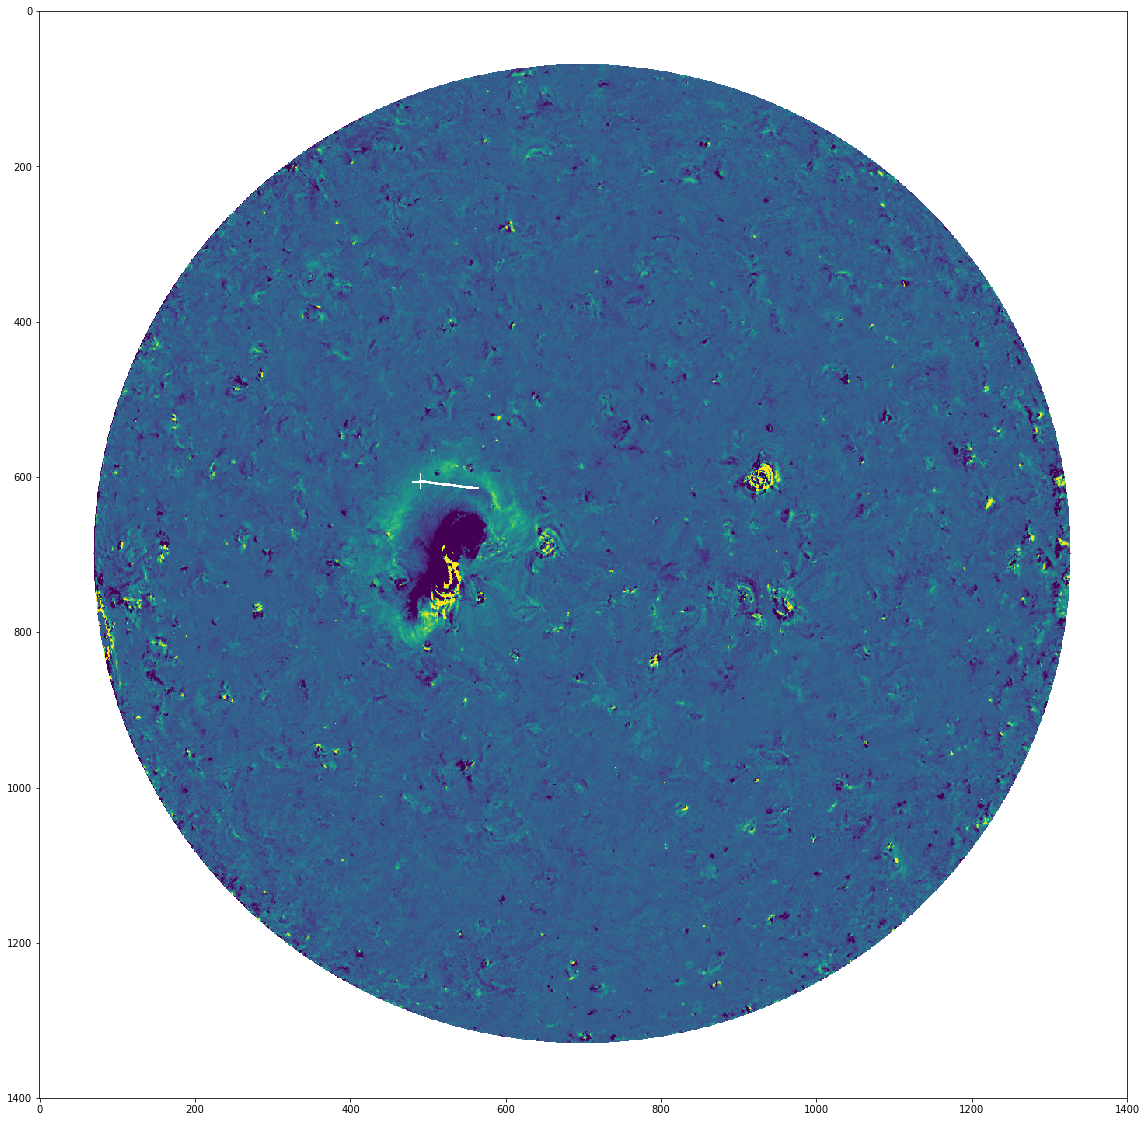

In [586]:
fig, (ax1) = plt.subplots(1,1, figsize=(20,20))

ax1.imshow(imA_with_line,vmin=-30,vmax=70)
#ax2.imshow(imB_with_line,vmin=-30,vmax=70)

### A

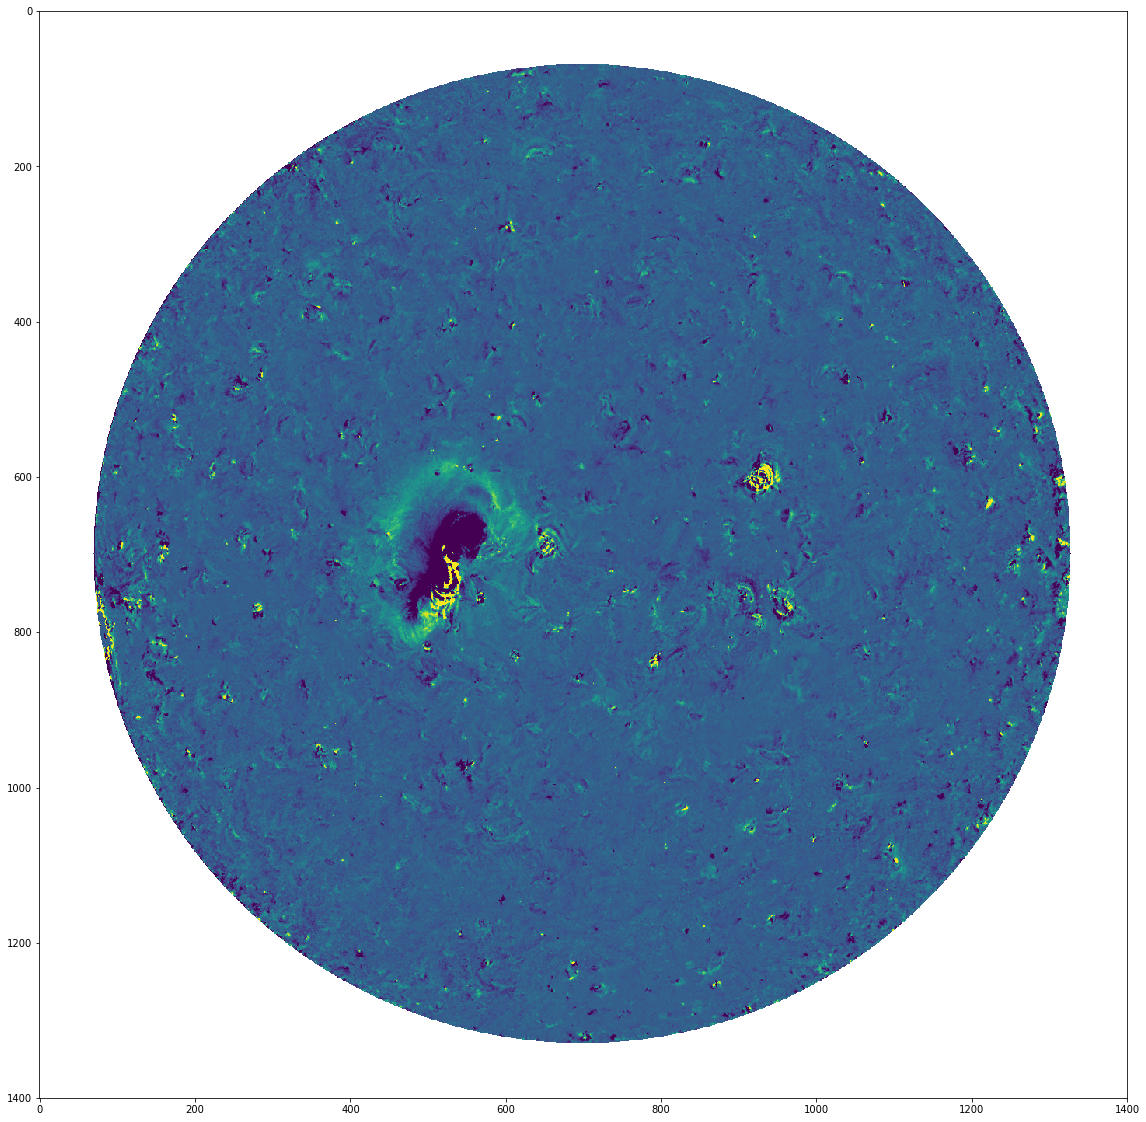

In [557]:
fig, (ax1) = plt.subplots(1,1, figsize=(20,20))

ax1.imshow(imA,vmin=-30,vmax=70)

### B

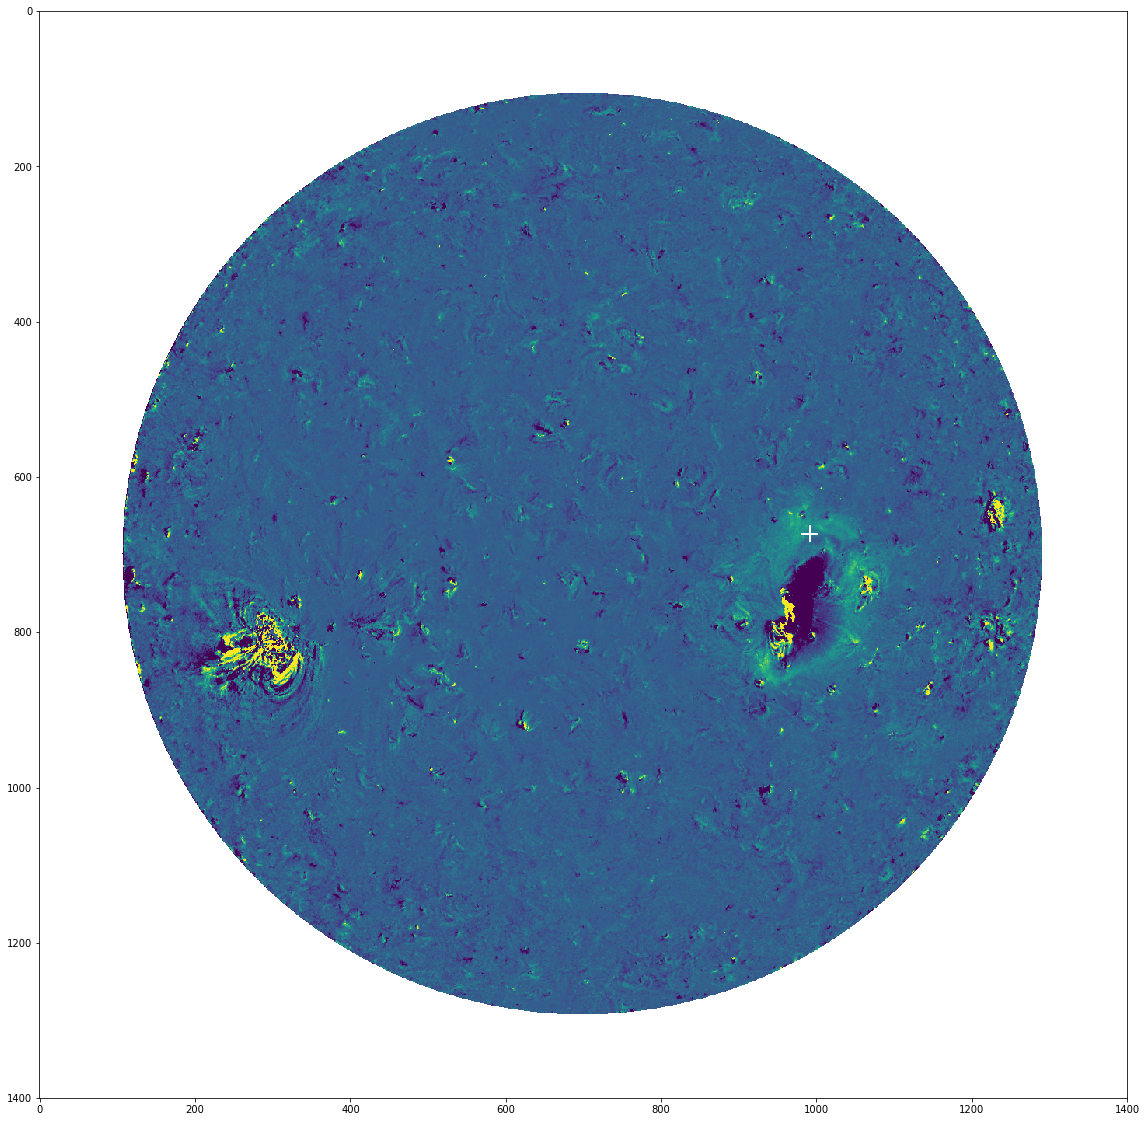

In [555]:
fig, (ax1) = plt.subplots(1,1, figsize=(20,20))

ax1.imshow(imB_with_line,vmin=-30,vmax=70)